In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
plt.rcParams["figure.facecolor"] = "w"
sns.set_style('whitegrid')

### Выбор метрики

In [4]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True, return_X_y=True)
df, target = data[0], data[1]

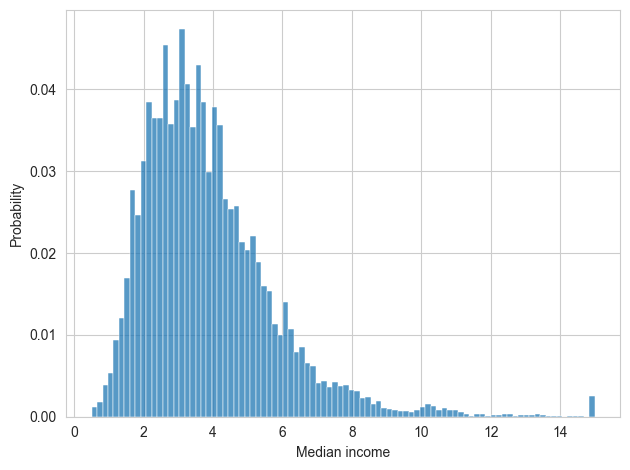

In [5]:
sns.histplot(df.MedInc, stat='probability')
plt.xlabel('Median income')
plt.tight_layout()
plt.savefig('income_dist.pdf')
plt.show()

### Разбиение на группы

In [6]:
users = [
    'user_id_1', 'user_id_2', 'user_id_3',
    'user_id_4', 'user_id_1', 'user_id_5',
]
df = pd.DataFrame.from_dict({'user': users})

In [7]:
df

,user
0,user_id_1
1,user_id_2
2,user_id_3
3,user_id_4
4,user_id_1
5,user_id_5


In [8]:
import hashlib

salt = 'my_first_experiment'
user = 'my_user_id'

value_str = user + salt
value_num = int(hashlib.md5(value_str.encode()).hexdigest(), 16)
value_num % 100

86

In [9]:
def get_group(user, salt, group_count):
    value_str = user + salt
    value_num = int(hashlib.md5(value_str.encode()).hexdigest(), 16)
    return value_num % group_count

In [10]:
df['group'] = df.user.apply(lambda user: get_group(user, 'any_salt', 2))
df['clicked'] = [1, 0, 0, 1, 0, 1]

In [11]:
df

,user,group,clicked
0,user_id_1,1,1
1,user_id_2,1,0
2,user_id_3,1,0
3,user_id_4,0,1
4,user_id_1,1,0
5,user_id_5,1,1


### Группы для AA

In [12]:
df = df.drop('group', axis=1)
df['aa_1'] = df.user.apply(lambda user: get_group(user, 'aa_1', 2))
df['aa_2'] = df.user.apply(lambda user: get_group(user, 'aa_2', 2))
df['aa_3'] = df.user.apply(lambda user: get_group(user, 'aa_3', 2))
df['aa_4'] = df.user.apply(lambda user: get_group(user, 'aa_4', 2))
df['aa_5'] = df.user.apply(lambda user: get_group(user, 'aa_5', 2))

In [13]:
df

,user,clicked,aa_1,aa_2,aa_3,aa_4,aa_5
0,user_id_1,1,0,0,1,0,0
1,user_id_2,0,1,1,0,0,1
2,user_id_3,0,1,1,1,0,1
3,user_id_4,1,1,0,1,0,1
4,user_id_1,0,0,0,1,0,0
5,user_id_5,1,0,1,1,1,1


### Пример некорректного AB

In [14]:
users_num = 1000

mean_user_ctr = 0.2
beta = 20
alpha = mean_user_ctr * beta / (1 - mean_user_ctr)

user_ctr = np.random.beta(alpha, beta, size=users_num)

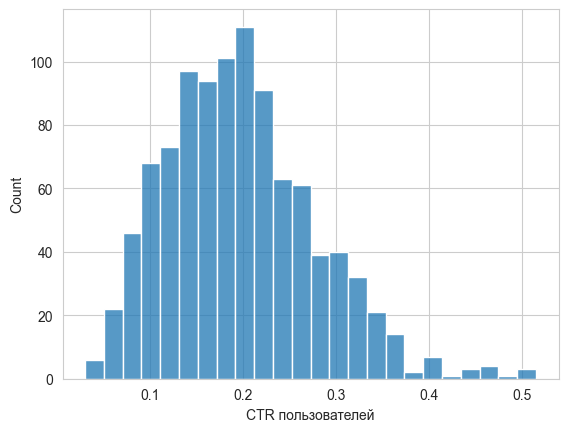

In [15]:
sns.histplot(user_ctr)
plt.xlabel('CTR пользователей')
plt.show()

In [16]:
views = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1

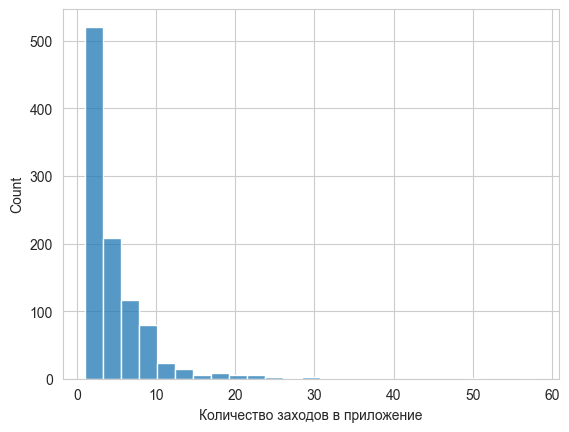

In [17]:
sns.histplot(views, bins=25)
plt.xlabel('Количество заходов в приложение')
plt.show()

Когда вы передаёте массивы в np.random.binomial(views, user_ctr), функция воспринимает каждый элемент этих массивов как параметр для отдельного биномиального распределения. По сути, это имитация проведения нескольких экспериментов (равного количеству просмотров) для каждого пользователя с его собственной вероятностью клика (user_ctr).

In [26]:
clicks = np.random.binomial(views, user_ctr)

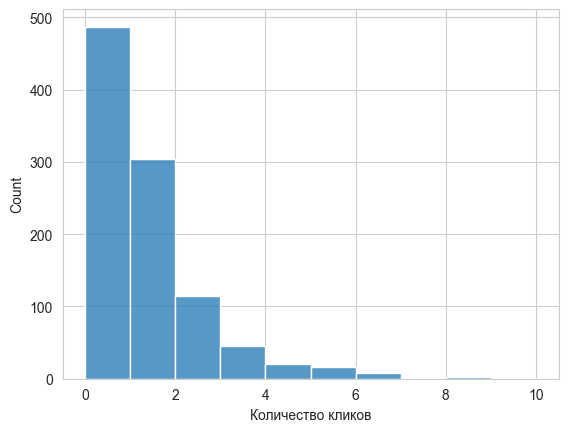

In [75]:
sns.histplot(clicks, bins=10)
plt.xlabel('Количество кликов')
plt.show()

In [83]:
sessions = []
for v, c in zip(views, clicks):
    sessions += [1] * c + [0] * (v - c)

In [84]:
sessions[:10]

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0]

In [85]:
np.mean(sessions)

0.19150707743547044

In [86]:
from statsmodels.stats.proportion import proportions_ztest


def get_pvalue():
    user_ctr = np.random.beta(alpha, beta, size=users_num)
    views = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
    clicks = np.random.binomial(views, user_ctr)

    mask = np.random.rand(len(views)) < 0.5
    views_1, clicks_1 = views[mask], clicks[mask]
    views_2, clicks_2 = views[~mask], clicks[~mask]

    sessions_1 = []
    for v, c in zip(views_1, clicks_1):
        sessions_1 += [1] * c + [0] * (v - c)

    sessions_2 = []
    for v, c in zip(views_2, clicks_2):
        sessions_2 += [1] * c + [0] * (v - c)

    return proportions_ztest(
        count=[sum(sessions_1), sum(sessions_2)],
        nobs=[len(sessions_1), len(sessions_2)]
    )[1]

In [87]:
pvalues = [get_pvalue() for _ in range(10000)]

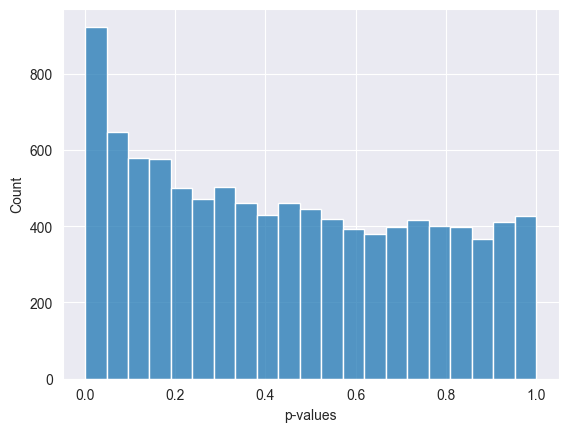

In [88]:
sns.histplot(pvalues)
plt.xlabel('p-values')
plt.show()

In [89]:
np.mean(np.array(pvalues) < 0.05)

0.0958

### Пример корректного подхода

In [99]:
from scipy.stats import mannwhitneyu


def get_pvalue():
    user_ctr = np.random.beta(alpha, beta, size=users_num)
    views = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
    clicks = np.random.binomial(views, user_ctr)

    mask = np.random.rand(len(views)) < 0.5
    views_1, clicks_1 = views[mask], clicks[mask]
    views_2, clicks_2 = views[~mask], clicks[~mask]

    return mannwhitneyu(clicks_1, clicks_2)[1]

In [100]:
pvalues = [get_pvalue() for _ in range(10000)]

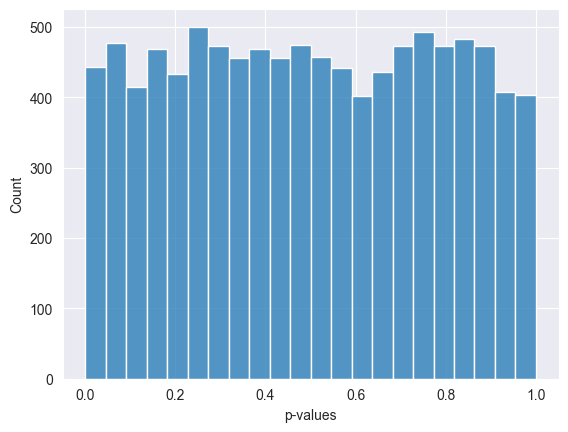

In [101]:
sns.histplot(pvalues)
plt.xlabel('p-values')
plt.show()

In [94]:
np.mean(np.array(pvalues) < 0.05)

0.0514

###  Оценка мощности

In [30]:
users_num = 1000

mean_user_ctr = 0.2
beta = 20


def get_clicks(effect=0.01):
    new_mean_user_ctr = mean_user_ctr + effect
    alpha = new_mean_user_ctr * beta / (1 - new_mean_user_ctr)
    user_ctr = np.random.beta(alpha, beta, size=users_num)
    views = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
    return np.random.binomial(views, user_ctr)

In [31]:
def get_pvalue():
    clicks_1 = get_clicks(effect=0)
    clicks_2 = get_clicks(effect=0.03)

    return mannwhitneyu(clicks_1, clicks_2)[1]

In [32]:
pvalues = [get_pvalue() for _ in range(10000)]

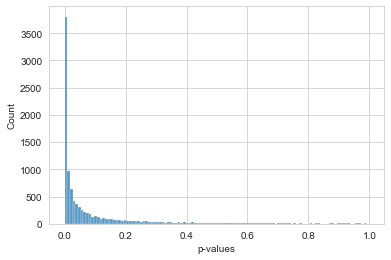

In [33]:
sns.histplot(pvalues)
plt.xlabel('p-values')
plt.show()

In [34]:
np.mean(np.array(pvalues) < 0.05)

0.6387

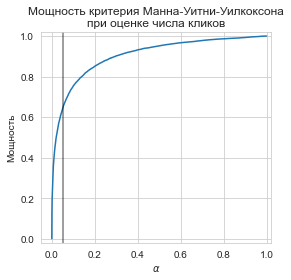

In [35]:
from scipy.stats import rankdata

sorted_pvalues = np.sort(pvalues)
position = rankdata(sorted_pvalues, method='ordinal')
cdf = position / sorted_pvalues.shape[0]
sorted_data = np.hstack((sorted_pvalues, 1))
cdf = np.hstack((cdf, 1))

plt.figure(figsize=(4, 4))
plt.plot(sorted_data, cdf, linestyle='solid')
plt.axvline(0.05, color='k', alpha=0.5)
plt.xlim(-0.05, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel(r'$\alpha$')
plt.ylabel('Мощность')
plt.title('Мощность критерия Манна-Уитни-Уилкоксона\nпри оценке числа кликов')
plt.tight_layout()
plt.savefig('power.pdf')
plt.show()

### Что влияет на мощность

In [36]:
from scipy.stats import norm

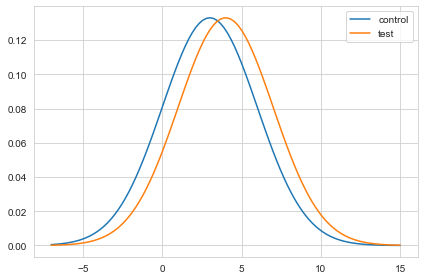

In [37]:
x = np.linspace(-7, 15, 100)

pdf = norm(loc=3, scale=3).pdf(x)
plt.plot(x, pdf, label='control')

pdf = norm(loc=4, scale=3).pdf(x)
plt.plot(x, pdf, label='test')

plt.legend(loc=1)
plt.tight_layout()
plt.savefig('diff_disp_1.pdf')
plt.show()

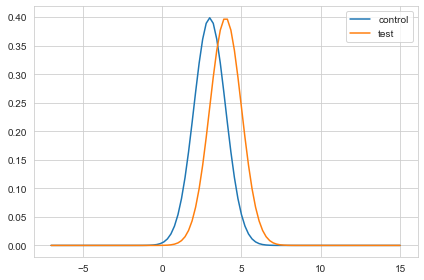

In [38]:
x = np.linspace(-7, 15, 100)

pdf = norm(loc=3, scale=1).pdf(x)
plt.plot(x, pdf, label='control')

pdf = norm(loc=4, scale=1).pdf(x)
plt.plot(x, pdf, label='test')

plt.legend(loc=1)
plt.tight_layout()
plt.savefig('diff_disp_2.pdf')
plt.show()

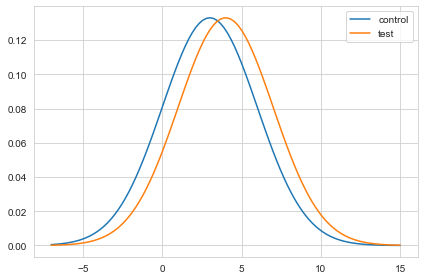

In [39]:
x = np.linspace(-7, 15, 100)

pdf = norm(loc=3, scale=3).pdf(x)
plt.plot(x, pdf, label='control')

pdf = norm(loc=4, scale=3).pdf(x)
plt.plot(x, pdf, label='test')

plt.legend(loc=1)
plt.tight_layout()
plt.savefig('diff_eff_1.pdf')
plt.show()

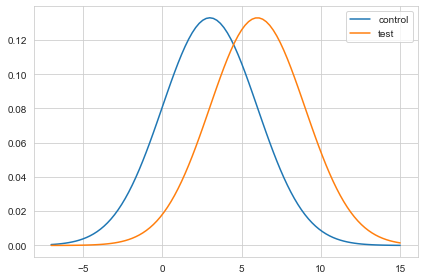

In [40]:
x = np.linspace(-7, 15, 100)

pdf = norm(loc=3, scale=3).pdf(x)
plt.plot(x, pdf, label='control')

pdf = norm(loc=6, scale=3).pdf(x)
plt.plot(x, pdf, label='test')

plt.legend(loc=1)
plt.tight_layout()
plt.savefig('diff_eff_2.pdf')
plt.show()

### Минимальный детектируемый эффект

In [41]:
N = 10000
sigma = 5
alpha = 0.05
power = 0.8

In [42]:
from scipy.stats import t

S = sigma * np.sqrt(2 / N)
M = t(N - 1).ppf(q=1 - alpha / 2) + t(N - 1).ppf(q=power)
M * S

0.1981213107344599

### Размер выборки для t-критерия Стьюдента

In [43]:
def calc_mde(N):
    S = sigma * np.sqrt(2 / N)
    M = t(N - 1).ppf(q=1 - alpha / 2) + t(N - 1).ppf(q=power)
    return M * S

In [44]:
x = np.linspace(100, 10000, 100)
mde = [calc_mde(n) for n in x]

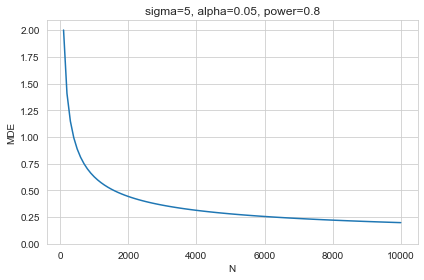

In [45]:
plt.plot(x, mde)
plt.xlabel('N')
plt.ylabel('MDE')
plt.title('sigma=5, alpha=0.05, power=0.8')
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig('mde.pdf')
plt.show()

### Размер выборки через AA

In [46]:
users_num = 1000

mean_user_ctr = 0.2
beta = 20


def get_clicks(effect=0.01):
    new_mean_user_ctr = mean_user_ctr + effect
    alpha = new_mean_user_ctr * beta / (1 - new_mean_user_ctr)
    user_ctr = np.random.beta(alpha, beta, size=users_num)
    views = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
    return np.random.binomial(views, user_ctr)

In [47]:
def get_pvalue(effect):
    clicks_1 = get_clicks(effect=0)
    clicks_2 = get_clicks(effect=effect)

    return mannwhitneyu(clicks_1, clicks_2)[1]

In [48]:
effects = np.arange(0, 0.07, 0.01)
power = []

for effect in effects:
    pvalues = [get_pvalue(effect=effect) for _ in range(1000)]
    power.append(np.mean(np.array(pvalues) < 0.05))

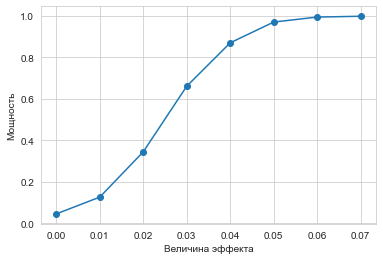

In [49]:
plt.plot(effects, power, 'o-')
plt.xlabel('Величина эффекта')
plt.ylabel('Мощность')
plt.show()